These are examples of typical variables and plots that we look at in our sea ice diagnostics package. The most current version of the sea ice diagnostics are in the CESM Postprocessing. More information here: [CESM Postprocessing](https://github.com/NCAR/CESM_postprocessing).

In exercise 1, you will learn about plotting sea ice area and other variables on a polar projection.

The first step is to import the libraries needed to plot the data. Here we will use `xarray` as a tool to read the netCDF file. We will use `numpy` for some basic math calculations. For plotting the data we will neet `matplotlib`, `pop_tools`, `geocat` and `cartopy`.

**Exercise 1: Plot Sea Ice Concentration on a polar projection.**

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import datetime
import glob
#import geocat.datafiles as gdf
import geocat.viz.util as gvutil
#from geocat.viz import cmaps as gvcmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import nc_time_axis

The next few steps read in sea ice concentration or `aice` from one of the CESM2 large ensemble historical runs. Note this operation points to multiple files on the campaign file system and so we are using the `xarray` function `open_mfdataset` for a multifile dataset. We will also print the `aice` dataset to get an idea of the metadata and dimensions. Note that we could use the 10 year simulation from the tutorial. However, 10 years is very short and is not a very interesting timeseries. Instead we can use one of the CESM2 Large Ensemble historical simulations. [Rodgers et al. 2021](https://doi.org/10.5194/esd-12-1393-2021)

In [2]:
files = "/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/aice/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cice.h.aice.*"

ds = xr.open_mfdataset(files)

aice = ds['aice']

print(aice)

<xarray.DataArray 'aice' (time: 1980, nj: 384, ni: 320)>
dask.array<concatenate, shape=(1980, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged


The next step is to read in some grid information for the `gx1v7` dipole grid used in POP and CICE. We will read in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Also, we will print the latitude array `TLAT` to see the metadata.

In [3]:
# get pop grid grid cell areas
grid = pop_tools.get_grid('POP_gx1v7')
grid

# convert tarea to m^2
tarea = grid['TAREA']/(1e4)

# get lat and lon
TLAT = grid['TLAT']
TLON = grid['TLONG']

TLATx = gvutil.xr_add_cyclic_longitudes(TLAT,"nlon")
TLONx = gvutil.xr_add_cyclic_longitudes(TLON,"nlon")

print(TLAT)

<xarray.DataArray 'TLAT' (nlat: 384, nlon: 320)>
array([[-79.22052261, -79.22052261, -79.22052261, ..., -79.22052261,
        -79.22052261, -79.22052261],
       [-78.68630626, -78.68630626, -78.68630626, ..., -78.68630626,
        -78.68630626, -78.68630626],
       [-78.15208992, -78.15208992, -78.15208992, ..., -78.15208992,
        -78.15208992, -78.15208992],
       ...,
       [ 71.29031715,  71.29408252,  71.30160692, ...,  71.30160692,
         71.29408252,  71.29031716],
       [ 71.73524335,  71.73881845,  71.74596231, ...,  71.74596231,
         71.73881845,  71.73524335],
       [ 72.18597561,  72.18933231,  72.19603941, ...,  72.19603941,
         72.18933231,  72.18597562]])
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      degrees_north
    long_name:  T-grid latitude


The next step is to set up the northern hemisphere polar stereographic projection for plotting the sea ice concentration `aice`. We are using a "rainbow" colormap here and cutting off the plot with a circular boundary. Note that we are only plotting the first timeslice of the `aice` array here.

Text(0.5, 1.0, 'Sea Ice Concentration')

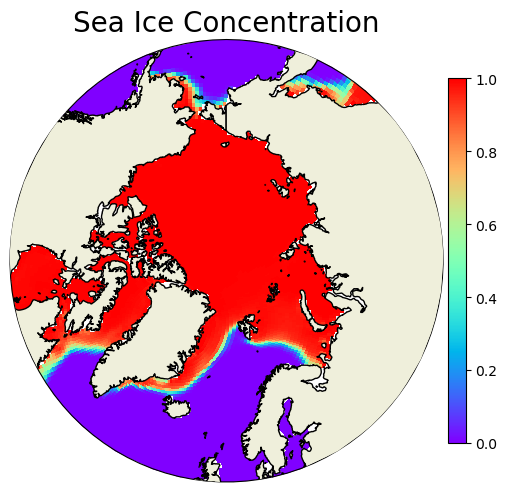

In [4]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('rainbow')  
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
this=ax.pcolormesh(TLONx,TLATx,
                   aice[0,:,:],
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
plt.title('Sea Ice Concentration',fontsize=20)

Things to try.

1. Try other colormaps here. Some examples to try: `viridis`, `plasma`, `Blues`. Try reversing the colormaps. Hint: add the string `_r` to the colormap name.

2. Try a different timeslice from aice. Note the number of timeslices in the metadata you printed above. Why does the number 1980 not work? Note that the calendar goes from 1850-01 to 2015-12 as these are monthly mean time slices. Can you compute an annual mean over the 165 years and plot that? Can you compute the September mean over the 165 years and plot that?

Hint: Use aice.mean(dim='time')

3. Try sea ice thickness `hi` now. What happens to the colorbar? Try increasing the maximum value `vmax`. Note that you have to change the files that are read in.

Hint: Do a search and replace on `aice` with `hi`.

4. Now how about the Southern Hemisphere?


<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

1. Colormaps
```
cmap = plt.cm.get_cmap('viridis')
cmap = plt.cm.get_cmap('plasma')
cmap = plt.cm.get_cmap('Blues')
cmap = plt.cm.get_cmap('Blues_r')
```
<br>

2. Means
```
this=ax.pcolormesh(TLONx,TLATx,
                   aice[1979,:,:],

aicemean = aice.mean(dim='time')

aicemean = aice[8::12,:,:].mean(dim='time')
```
<br>

3. Ice Thickness
```
- change all occurences of `aice` to `hi`
- Try `vmax = 5`
```

4. Southern Hemisphere
```
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([0.005, 360, -90, -55], crs=ccrs.PlateCarree())
```

</details>
</div>

**Exercise 2: Plot a time series of total sea ice area.**

The first step is to compute total ice area. First we will do this for the northern hemisphere. The total ice area involves the `tarea` array as above. First we create a mask for the northern hemisphere.

In [5]:
mask = np.where(TLAT > 0, 1, 0)

nharea = mask * tarea.values

aice_masked = np.where(np.isnan(aice.values),0,aice)

Next we compute the total area as a multi-dimenstional dot product of the ice area and masked tarea. This uses the python NumPy function `tensordot` to do a multi-dimensional dot product. This basically does a sum over the two spatial dimensions. [Python tensordot](https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html)

In [14]:
totalarea = np.tensordot(aice_masked,nharea,axes=2)*1.0e-12

totalarea

array([13.20975381, 13.67388539, 13.80489485, ...,  3.09018846,
        7.39698358,  9.91173288])

Next we create a time axis to go with the data. Hopefully we can fix this using nc-time-axis very soon.

In [13]:
time = ds['time']
totarea = xr.DataArray(data=totalarea,coords={"time":time})

totarea

<xarray.DataArray (time: 1980)>
array([13.20975381, 13.67388539, 13.80489485, ...,  3.09018846,
        7.39698358,  9.91173288])
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00

Now plot the total area. 

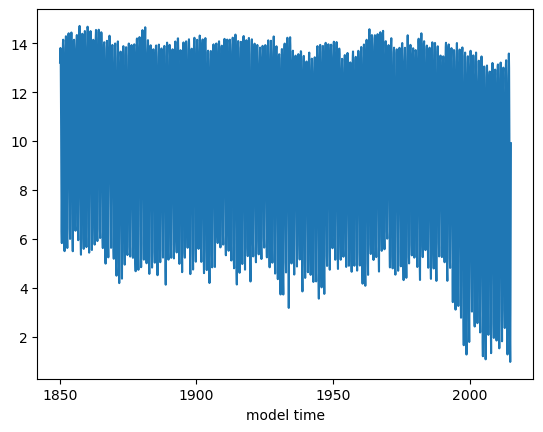

In [10]:
totarea.plot()

This plot looks very noisy! Why do you think this is? Hint: you have plotted how many years of monthly mean data? Let's try just plotting September instead. Hint: By subsetting the totarea area starting at September (8 in 0 based indexing) and then going every twelve slices.

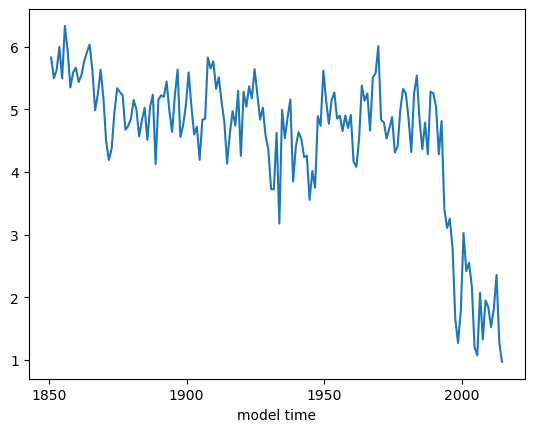

In [11]:
totarea[8::12].plot()

Things to try:

1. Try plotting the March total area time series. Hint: The first March is slice 2.

2. Try computing total ice volume and plotting it. Hint: Use the variable `hi` in place of `aice`. Note that volume is units of $m^3$. So, you might want to scale the volume by $1.0e-13$.

3. What does the Southern Hemisphere sea ice area and volume look like?

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

1. March total area.
```
totarea[2::12}.plot()
```
<br>

2. Ice Volume
```
hi_masked = np.where(np.isnan(hi.values),0,hi)

totalvolume = np.tensordot(hi_masked,nharea,axes=2)*1.0e-13
```
<br>
    
3. Southern Hemisphere
```
mask = np.where(TLAT < 0, 1, 0)
```
    
</details>
</div>